# pybvh tutorial 2 - spatial coordinates

In [1]:
import numpy as np
np.set_printoptions(precision=3)

import sys
sys.path.append('../')

import pybvh
import matplotlib.pyplot as plt
from pathlib import Path

bvh_folder = Path('../bvh_data')

# Obtaining spatial coordinates

A lot of machine learning models studying skeleton movement recogition work with the joints position being given by spatial coordinates. Furthermore, frameworks to estimate human skeleton from video (OpenPose, AlphaPose etc.) return 3D spatial coordinates for the estimations of the skeleton joints positions. It is also easier to plot a 3D skeleton with plotting libraries (such as mathplotlab) with 3d coordinates. For all those reasons, it would be very handy to be able to easily get the 3D spatial coordinates of our joints in every frames.

We can obtain a raw numpy array containing the spatial coordinates using the bvh class method `get_spatial_coord()`.

In [2]:
filepath = bvh_folder / 'bvh_test2.bvh'

bvh_example = pybvh.read_bvh_file(filepath)

In [3]:
spatial_coord = bvh_example.get_spatial_coord()
print('The shape of the spatial coordinates numpy array is ', spatial_coord.shape)
print('Let us look at the third row for example')
print("(for readability here we only print the first 9 columns, meaning the position of the first 3 joints)")
spatial_coord[2, :9] 

The shape of the spatial coordinates numpy array is  (61, 84)
Let us look at the third row for example
(for readability here we only print the first 9 columns, meaning the position of the first 3 joints)


array([148.846,  95.54 , -16.373, 147.09 , 105.501, -13.663, 147.124,
       117.007, -12.63 ])

By looking at the shape of the array, you may have noticed that it has more columns than what we obtained with the euler angles. Indeed, here we added the spatial position of the End sites nodes, which were missing in the rotational data.

`get_spatial_coord()` can take up to 3 optional arguments: `frame_num`, `centered` and `change_skeleton`. We will see the use of each one, starting with `frame_num`. By default, `get_spatial_coord()` return the whole bvh sequences with joints as spatial coordinates, but by giving a positive integer as a parameter to `frame_num`, we can force the function to only return the spatial coordinates of the frame indexed by this parameter. 

In [4]:
spatial_frame = bvh_example.get_spatial_coord(frame_num=5)
spatial_frame.shape

(84,)

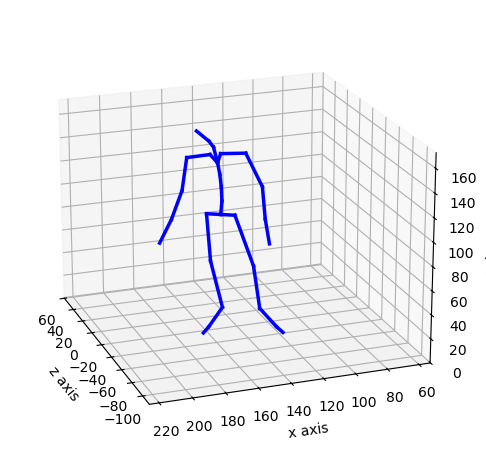

In [5]:
fig, ax = pybvh.plot.plot_frame(bvh_example, spatial_frame)
plt.show()

## Centering the data

The first 3 numbers of the array represent the hips coordinate. By default, the method `get_spatial_coord()` returns *world coordinates*. World coordinates are the position of the hips and joints as recorded in the bvh file. This behavior is directed by the `centered` argument, which has three possible modes.
- `centered = "world"`: default behavior, the skeleton is in the location strictly as described in the bvh file.
- `centered = "first"`: the data is centered such as the the first frame root position is considered to be [0, 0, 0]. From there, the skeleton moves in the space normally.
- `centered = "skeleton"`:  the coordinates are local to the skeleton (meaning the root coordinates are considered to be [0, 0, 0] in ALL frames).

Example of centering the data on the first frame (we look at the first 3 frames). Notice how the coordinates of the root are 0, 0, 0, but only for the first frame.

In [6]:
centered_first_spatial_coord = bvh_example.get_spatial_coord(centered="first")
centered_first_spatial_coord[:3, :9]

array([[ 0.000e+00,  0.000e+00,  0.000e+00, -1.756e+00,  9.962e+00,
         2.709e+00, -1.721e+00,  2.147e+01,  3.736e+00],
       [ 1.090e-02,  4.180e-04,  1.690e-02, -1.745e+00,  9.963e+00,
         2.727e+00, -1.710e+00,  2.147e+01,  3.756e+00],
       [ 1.658e-02,  1.354e-03,  1.802e-02, -1.740e+00,  9.963e+00,
         2.729e+00, -1.706e+00,  2.147e+01,  3.761e+00]])

We can also plot the same frame as previously, and notice that the coordinates have changed so that the root is (nearly) at the origin this time.

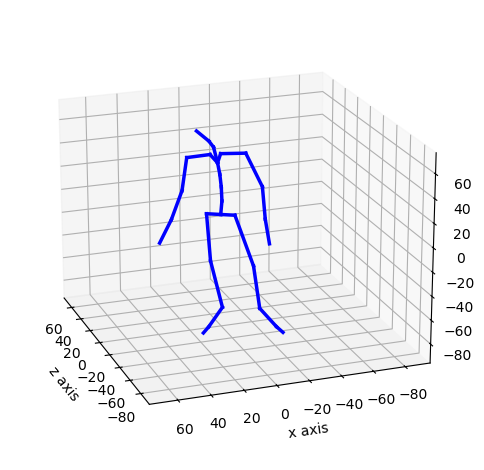

In [7]:
fig, ax = pybvh.plot.plot_frame(bvh_example, centered_first_spatial_coord[5])
plt.show()

Example of centering the data on the skeleton itself. Notice how the coordinates of the root are 0, 0, 0 for all the frames.

In [8]:
centered_skel_spatial_coord = bvh_example.get_spatial_coord(centered="skeleton")
centered_skel_spatial_coord[:3, :9]

array([[ 0.   ,  0.   ,  0.   , -1.756,  9.962,  2.709, -1.721, 21.468,
         3.736],
       [ 0.   ,  0.   ,  0.   , -1.756,  9.962,  2.71 , -1.721, 21.468,
         3.739],
       [ 0.   ,  0.   ,  0.   , -1.756,  9.962,  2.711, -1.722, 21.468,
         3.743]])

## Using a different skeleton

By default, to calculate the coordinates of every joints, `get_spatial_coord()` use the joints rotational data as well as the joints offset described in the bvh `nodes` components. However in some case we may want to use different offset - for example, if we want to normalize the data by using a common skeleton for different bvh files. In this case, we can give the bvh object of the other skeleton we want to use through the `change_skeleton` parameters.

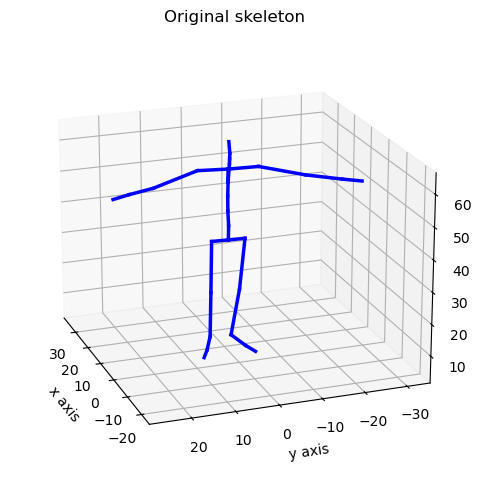

In [9]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

spatial_frame = bvh.get_spatial_coord(frame_num=5)

fig, ax = pybvh.plot.plot_frame(bvh, spatial_frame)
ax.set_title('Original skeleton')
plt.show()

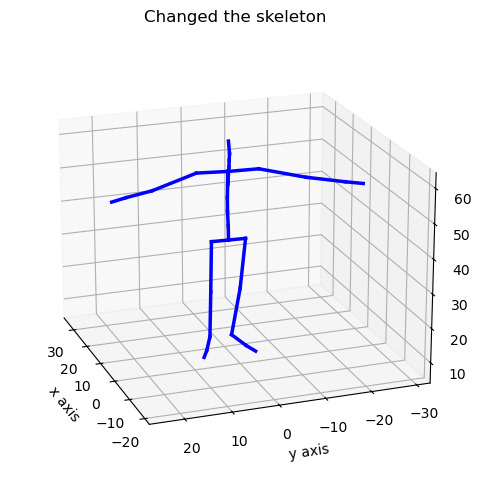

In [10]:
other_skeleton_filepath = bvh_folder / 'standard_skeleton.bvh'
bvh_other_skeleton = pybvh.read_bvh_file(other_skeleton_filepath)

change_skel_spatial_frame = bvh.get_spatial_coord(frame_num=5, change_skeleton=bvh_other_skeleton)

fig, ax = pybvh.plot.plot_frame(bvh, change_skel_spatial_frame)
ax.set_title('Changed the skeleton')
plt.show()

Because the skeletons between the 2 files are very close from each other, it is difficult to see the difference on the plot. However, looking at the coordinates of the joints, we instantly understand that they are not at the same place in space (except the first 3 numbers, which represent the root position and therefore are at the same place in space)

In [11]:
print('3D coordinates with the original skeleton:')
print(spatial_frame[:9])
print('3D coordinates with the changed skeleton:')
print(change_skel_spatial_frame[:9])


3D coordinates with the original skeleton:
[ 9.27  -0.764 36.259  9.318 -0.851 40.711 10.12  -0.965 45.089]
3D coordinates with the changed skeleton:
[ 9.27  -0.764 36.259  9.693 -0.854 40.254 10.409 -0.956 44.148]


# Pandas Dataframes with spatial coordinates

In [12]:
import pandas as pd

Though numpy array are perfect for quick computation, they are not very explicit. To make more sense of those spatial coordinates, we can once more use pandas. The method `get_df_constructor()` has a parameter `mode`, which accept 2 possibilities:
- `mode='euler'` (by default): returns a Dataframe constructor with the euler angles as data, 
- `mode='coordinates'`: returns a Dataframe constructor with the spatial coordinates as data. In this mode, we can also precise how we want to center the coordinates.

In [13]:
df_coord = pd.DataFrame(bvh.get_df_constructor(mode='coordinates', centered='first'))
df_coord.head()

,time,Hips_X,Hips_Y,Hips_Z,Spine_X,Spine_Y,Spine_Z,Spine1_X,Spine1_Y,Spine1_Z,...,LeftLeg_Z,LeftFoot_X,LeftFoot_Y,LeftFoot_Z,LeftToeBase_X,LeftToeBase_Y,LeftToeBase_Z,End Site LeftToeBase_X,End Site LeftToeBase_Y,End Site LeftToeBase_Z
0,0.000000,0.0000,0.0000,0.0000,0.047527,-0.084642,4.451772,0.835485,-0.204464,8.832691,...,-16.625785,2.528696,-1.626123,-32.353930,-1.814848,-3.511760,-33.946539,-4.907681,-4.861664,-34.608022
1,0.033333,-0.0458,-0.0010,-0.0028,0.001573,-0.086142,4.448964,0.791559,-0.205374,8.829534,...,-16.628189,2.528168,-1.626181,-32.353203,-1.815141,-3.511740,-33.946543,-4.907867,-4.861521,-34.608776
2,0.066667,-0.0958,-0.0020,-0.0059,-0.048418,-0.087781,4.445852,0.744598,-0.206567,8.825886,...,-16.630855,2.527316,-1.626564,-32.352585,-1.815855,-3.512307,-33.946086,-4.908391,-4.862205,-34.608964
3,0.100000,-0.1450,-0.0021,-0.0094,-0.098618,-0.088621,4.442348,0.696294,-0.207246,8.822043,...,-16.634356,2.526102,-1.626489,-32.351841,-1.816360,-3.512412,-33.947061,-4.908629,-4.862481,-34.610839
4,0.133333,-0.1998,-0.0085,-0.0134,-0.152634,-0.094917,4.438342,0.645839,-0.211599,8.817441,...,-16.636725,2.525258,-1.627009,-32.350633,-1.816885,-3.512833,-33.946837,-4.908618,-4.862758,-34.613397
